In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{wasysym}')


import scipy.integrate as si
import scipy as sp
import scipy.optimize as so
import scipy.interpolate as st #sinterp

Abs=np.abs
Log=np.log
Log10=np.log10
Pi=np.pi
ArcTanh=np.arctanh
Sqrt=np.sqrt
Exp=np.exp
Cos=np.cos
Sin=np.sin
Arg=np.angle
BesselK=sp.special.kv
Erf=sp.special.erf
HeavisideTheta=lambda x: np.heaviside(x,0)
def Plot(fun,xminmax,n=100):
    xlist=np.linspace(xminmax[0],xminmax[1],n)
    ylist=[fun(x) for x in xlist]
    plt.plot(xlist,ylist)
    
import time
def Timing_begin():
    global time_start
    time_start=time.time()
def Timing_end():
    Δt=time.time()-time_start
    print("time used:",Δt)
    
    
    
def max_pos(L):
    if type(L)==np.ndarray:
        L=L.tolist()
    max_value = max(L)
    max_index = L.index(max_value)
    return max_value,max_index
    

In [2]:
def g_lgM2(lgM2, m,which="V"):
    if which=="V":
        return (10**lgM2*3/2) **0.5/m
    if which=="S":
        return (10**lgM2) **0.5/m

In [3]:
Erf(1.2)

0.9103139782296353

# m-g curve

In [4]:
def get_lgM2_bounds(M2_Neff,m_list,cut):
    lgM2_bounds=[]
    for i,m in enumerate(m_list):
        data=M2_Neff[i]
        
        
        maxNeff,pos=max_pos(data["ΔNeff"])

        L_bound,H_bound=None,None
        
        #try to obtain L_bound
        if data["ΔNeff"][0]>cut:
            L_bound=extrapolate_to_lowNeff(cut,data)
        elif maxNeff>cut:
            sol=so.root_scalar(lambda lgM2: np.interp(lgM2,data["lgM2"],data["ΔNeff"])-cut,
                           bracket=[data["lgM2"][0],data["lgM2"][pos]]
                          )
            L_bound=1.0*sol.root  
            
        #try to obtain H_bound    
        if (maxNeff>cut) and data["ΔNeff"][-1]<cut:
            sol=so.root_scalar(lambda lgM2: np.interp(lgM2,data["lgM2"],data["ΔNeff"])-cut,
                   bracket=[data["lgM2"][pos],data["lgM2"][-1]]
                  )
            H_bound=1.0*sol.root  
        
        lgM2_bounds.append({"L":L_bound,"H":H_bound})   
    return lgM2_bounds


def m_g_curve(lgM2_bounds,m_list,which):
    m_g_list=[]
    for i,m in enumerate(m_list):
        lgM2=lgM2_bounds[i]["L"]
        if  lgM2 != None:
            m_g_list.append([m, g_lgM2(lgM2, m,which)])

    for i in range(len(m_list)-1,-1,-1):
        lgM2=lgM2_bounds[i]["H"];m=m_list[i];
        if  lgM2 !=None:
            m_g_list.append([m,g_lgM2(lgM2, m,which) ])
    return np.array(m_g_list) 

def extrapolate_to_lgM2(lgM2,result,i1=0,i2=1):
    x1,x2=result["lgM2"][i1],result["lgM2"][i2]
    y1,y2=Log(result["ΔNeff"][i1]),Log(result["ΔNeff"][i2])
    x0=lgM2
    y0=(x0*y1 - x2*y1 - x0*y2 + x1*y2)/(x1 - x2) #see 20230717.nb
    return Exp(y0)

def extrapolate_to_lowNeff(lowNeff,result,i1=0,i2=1):
    x1,x2=result["lgM2"][i1],result["lgM2"][i2]
    y1,y2=Log(result["ΔNeff"][i1]),Log(result["ΔNeff"][i2])
    y0=Log(lowNeff)
    x0=(x1*y0 - x2*y0 + x2*y1 - x1*y2)/(y1 - y2)  #see 20230717.nb
    return x0

def extrapolate_linear(x0,data,i1=0,i2=1):
    x1,x2=data[i1,0],data[i2,0]
    y1,y2=data[i1,1],data[i2,1]
    y0=(x0*y1 - x2*y1 - x0*y2 + x1*y2)/(x1 - x2) #see 20230717.nb
    return y0

def extrapolate_linear_y(y0,data,i1=0,i2=1):
    x1,x2=data[i1,0],data[i2,0]
    y1,y2=data[i1,1],data[i2,1]
    x0=(x1*y0 - x2*y0 + x2*y1 - x1*y2)/(y1 - y2)  #see 20230717.nb
    return x0

In [5]:
def get_curve_data(cut=0.285,which="V"):
    global data_a, data_b
    postfix={"V":"","S":"-phi"}[which]
    M2_Neff=np.load("data/M2-Neff-above1MeV"+postfix+".npy", allow_pickle=True)
    m_list=np.load("data/M2-Neff-above1MeV"+postfix+"_mlist.npy", allow_pickle=True)    
    data_a=m_g_curve( get_lgM2_bounds(M2_Neff,m_list,cut) ,m_list, which)

    M2_Neff=np.load("data/M2-Neff-below1MeV"+postfix+".npy", allow_pickle=True)
    m_list=np.load("data/M2-Neff-below1MeV"+postfix+"_mlist.npy", allow_pickle=True)    
    data_b=m_g_curve( get_lgM2_bounds(M2_Neff,m_list,cut) ,m_list,which)
    
    curve_data=np.concatenate([data_b,data_a])
    return curve_data

In [6]:
def ax_set(ax,xylabel=[r"$m_{Z'}$ [MeV]",r"$g_{Z'}$",r"$g_{Z'}$"]):
#     ax.plot([1]*2,[1e-17,1e-7],color="gray",ls="--")
#     ax.text(s=r"$\to$ BR-dependent",x=1,y=2e-14)

    ax.set_xlabel(xylabel[0],fontsize=14)
    ax.set_ylabel(xylabel[1],fontsize=14)
    ax.tick_params(which='both', direction='in')
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_ylim(1e-14,1e-7)
    ax.set_xlim(0.6e-5,1e2)
    

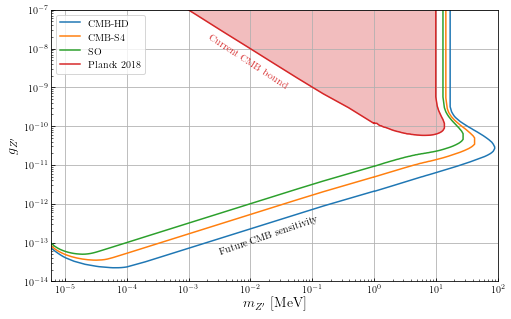

In [7]:
fig, axs=plt.subplots(ncols=1,figsize=[8,5],sharey=False)
ax=axs
labels=["CMB-HD","CMB-S4","SO","Planck 2018"]
for i,cut in enumerate([0.028,0.06,0.1,0.285]):
    data=get_curve_data(cut,which="V")
    data=np.concatenate((data,[[data[-1,0],1e0]]  ))
    if i==3:
        ax.fill_between(data[:,0],data[:,1],data[:,1]*0+1e-7,color="C3",alpha=0.3) 
        data_Planck_V=np.copy(data)
       
    ax.plot(data[:,0],data[:,1],label=labels[i]) 

ax.text(s="Current CMB bound",x=2e-3,y=1e-9,rotation=-33,color="C3")
ax.text(s="Future CMB sensitivity",x=3e-3,y=0.5e-13,rotation=19,color="k")

ax_set(ax)

plt.legend()
plt.grid()
# plt.savefig("../fig/m-g.pdf",bbox_inches='tight')
plt.show()

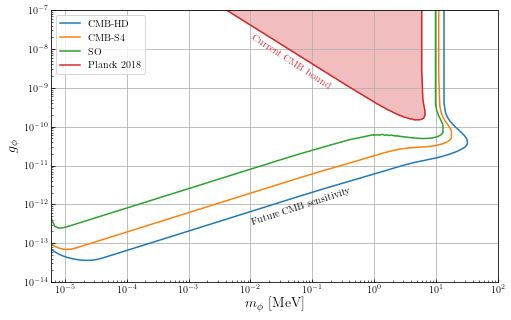

In [8]:
fig, axs=plt.subplots(ncols=1,figsize=[8,5],sharey=False)
ax=axs

labels=["CMB-HD","CMB-S4","SO","Planck 2018"]
for i,cut in enumerate([0.028,0.06,0.1,0.285]):
    data=get_curve_data(cut,which="S")
    data=np.concatenate((data,[[data[-1,0],1e0]]  ))
    if i==3:
        ax.fill_between(data[:,0],data[:,1],data[:,1]*0+1e-7,color="C3",alpha=0.3) 
        data_Planck_S=np.copy(data)
        
    ax.plot(data[:,0],data[:,1],label=labels[i]) 

ax.text(s="Current CMB bound",x=1e-2,y=1e-9,rotation=-33,color="C3")
ax.text(s="Future CMB sensitivity",x=1e-2,y=3e-13,rotation=18,color="k")

ax_set(ax,[r"$m_{\phi}$ [MeV]",r"$g_{\phi}$",r"$g_{Z'}$"])

plt.legend()
plt.grid()
# plt.savefig("../fig/m-g-phi.pdf",bbox_inches='tight')
plt.show()

# Neff-g curve

0.01


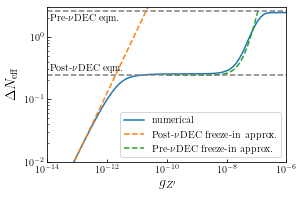

In [9]:
fig, ax=plt.subplots(ncols=1,figsize=[6*5/7,4*5/7],sharey=False)

M2_Neff=np.load("data/M2-Neff-bench.npy", allow_pickle=True)
m_list=np.load("data/M2-Neff-bench_mlist.npy", allow_pickle=True)   

i=1;
m=m_list[i];print(m);


Neff_lgM2=M2_Neff[i]
lgM2_0=-25+3*Log10(m)
Neff_0=extrapolate_to_lgM2(lgM2_0,Neff_lgM2)

lgM2_x=-10
Neff_x=Neff_lgM2["ΔNeff"][-1]

lgM2_list=np.concatenate([[lgM2_0],Neff_lgM2["lgM2"],[lgM2_x]])

g_list=g_lgM2(lgM2_list, m,which="V")

# gc_list=None

Neff_list=np.concatenate([[Neff_0],Neff_lgM2["ΔNeff"],[Neff_x]])

# plt.plot(g_list,Neff_list,label=r"$m_{Z'}$="+str_m(m))
plt.plot(g_list,Neff_list,label=r"numerical")
plt.plot(g_list,0.04*(g_list/1e-13)/Sqrt(m/0.001),ls="--",label=r"Post-$\nu$DEC freeze-in approx.")

g=np.geomspace(1e-10,1e-6)
plt.plot(g,0.242+1.86e18*g**2*m**2,ls="--",label=r"Pre-$\nu$DEC freeze-in approx.")
g=None

plt.plot([1e-14,1e-6],[2.53]*2,color="gray",ls="--")
plt.text(x=1.2e-14,y=1.8,s=r"Pre-$\nu$DEC eqm.")
plt.plot([1e-14,1e-6],[0.242]*2,color="gray",ls="--")
plt.text(x=1.2e-14,y=0.29,s=r"Post-$\nu$DEC eqm.")

plt.legend()
plt.ylim(0.01,3)
plt.xlim(1e-14,1e-6)

ax.set_xlabel(r"$g_{Z'}$",fontsize=14)
ax.set_ylabel(r"$\Delta N_{\rm eff}$",fontsize=14)
ax.tick_params(which='both', direction='in')
ax.set_xscale("log")
ax.set_yscale("log")

# plt.savefig("../fig/Neff-g-approx.pdf",bbox_inches='tight')

20.0


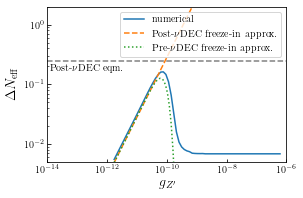

In [10]:
fig, ax=plt.subplots(ncols=1,figsize=[6*5/7,4*5/7],sharey=False)

M2_Neff=np.load("data/M2-Neff-bench.npy", allow_pickle=True)
m_list=np.load("data/M2-Neff-bench_mlist.npy", allow_pickle=True)   

i=-1;
m=m_list[i];print(m);


Neff_lgM2=M2_Neff[i]
lgM2_0=-25+3*Log10(m)
Neff_0=extrapolate_to_lgM2(lgM2_0,Neff_lgM2)

lgM2_x=-10
Neff_x=Neff_lgM2["ΔNeff"][-1]

lgM2_list=np.concatenate([[lgM2_0],Neff_lgM2["lgM2"],[lgM2_x]])

g_list=g_lgM2(lgM2_list, m,which="V")

# gc_list=None

Neff_list=np.concatenate([[Neff_0],Neff_lgM2["ΔNeff"],[Neff_x]])

# plt.plot(g_list,Neff_list,label=r"$m_{Z'}$="+str_m(m))
plt.plot(g_list,Neff_list,label=r"numerical")
plt.plot(g_list,0.04*(g_list/1e-13)/Sqrt(m/0.001),ls="--",label=r"Post-$\nu$DEC freeze-in approx.")

g=np.geomspace(1e-12,1e-9)
#(5.6e19*g**2)/Exp(1.1e19*g**2*m),
#(g*(1.4e10 - 1.4e10*Erf(3.3e9*g*Sqrt(m))))/Sqrt(m),
#(-1.3947668429729647e10*Exp((2.7885028517364466e20*g**2)/m)*g*(-1. + \
# 1.*Erf(3.339762178201584e9*g*Sqrt(m))))/Sqrt(m)
#(g*(1.4e10 - 1.4e10*Erf(3.3e9*g*Sqrt(m))))/Sqrt(m)
gm=g/1e-10 *(m/10)**0.5; mx=m/10
plt.plot(g,0.5*gm**2*Exp(-gm**2)/mx+(0.4*gm*(1 - Erf(gm)))/mx,
         ls=":",label=r"Pre-$\nu$DEC freeze-in approx.")
g=None

# plt.plot([1e-14,1e-6],[2.53]*2,color="gray",ls="--")
# plt.text(x=1.2e-14,y=2.0,s=r"Pre-$\nu$DEC eqm.")
plt.plot([1e-14,1e-6],[0.242]*2,color="gray",ls="--")
plt.text(x=1.2e-14,y=0.17,s=r"Post-$\nu$DEC eqm.")

plt.legend()
plt.ylim(0.005,2)
plt.xlim(1e-14,1e-6)

ax.set_xlabel(r"$g_{Z'}$",fontsize=14)
ax.set_ylabel(r"$\Delta N_{\rm eff}$",fontsize=14)
ax.tick_params(which='both', direction='in')
ax.set_xscale("log")
ax.set_yscale("log")

# plt.savefig("../fig/Neff-g-approx2.pdf",bbox_inches='tight')

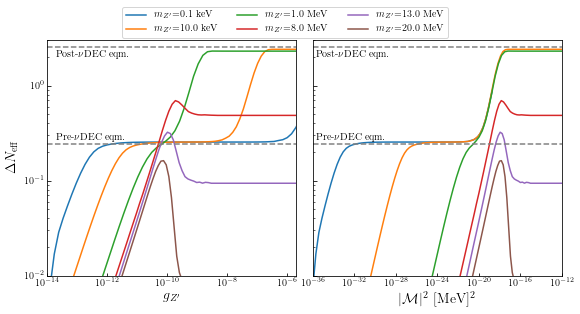

In [11]:
fig, axs=plt.subplots(ncols=2,figsize=[8,4],sharey=True)

ax0,ax1=axs

M2_Neff=np.load("data/M2-Neff-bench.npy", allow_pickle=True)
m_list=np.load("data/M2-Neff-bench_mlist.npy", allow_pickle=True)   


def str_m(m):
    if m>=1:
        return str(m)+" MeV"
    else:
        return str(1000*m)+" keV"

for i,m in enumerate(m_list):
    Neff_lgM2=M2_Neff[i]
    lgM2_0=-25+3*Log10(m)
    Neff_0=extrapolate_to_lgM2(lgM2_0,Neff_lgM2)
    
    lgM2_x=-8
    if i==0:lgM2_x=Neff_lgM2["lgM2"][-1]
        
    Neff_x=Neff_lgM2["ΔNeff"][-1]
    
    lgM2_list=np.concatenate([[lgM2_0],Neff_lgM2["lgM2"],[lgM2_x]])
    g_list=g_lgM2(lgM2_list, m,which="V")
    Neff_list=np.concatenate([[Neff_0],Neff_lgM2["ΔNeff"],[Neff_x]])
    
    ax0.plot(g_list,Neff_list,label=r"$m_{Z'}$="+str_m(m))
    ax1.plot(10**lgM2_list,Neff_list,label=r"$m_{Z'}$="+str_m(m))


for i,ax in enumerate(axs):
    xminmax=[[1e-14,2e-6],[1e-36,1e-12]][i]
    ax.plot(xminmax,[2.53]*2,color="gray",ls="--")
    ax.text(x=xminmax[0]*2,y=2.0,s=r"Post-$\nu$DEC eqm.")
    ax.plot(xminmax,[0.242]*2,color="gray",ls="--")
    ax.text(x=xminmax[0]*2,y=0.27,s=r"Pre-$\nu$DEC eqm.")

# ax1.text(s="smaller\n $m_{Z'}$",x=1e-33,y=5e-2,rotation=-20)  

    
ax0.set_ylim(0.01,3)
ax0.set_xlim(1e-14,2e-6)
ax1.set_xlim(1e-36,1e-12)



for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.tick_params(which='both', direction='in')

ax1.set_xlabel(r"$|{\cal M}|^{2}$ [MeV]$^2$",fontsize=14)
ax0.set_ylabel(r"$\Delta N_{\rm eff}$",fontsize=14)
ax0.set_xlabel(r"$g_{Z'}$",fontsize=14)
plt.tight_layout(w_pad=0.2)

ax0.legend(loc=[0.3,1.01],ncol=3)
# plt.savefig("../fig/Neff-g-M2.pdf",bbox_inches='tight')